In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/MyDrive/Stroke

!pip install nilearn
!pip install monai

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/Stroke'
/content/gdrive/MyDrive/Stroke


In [ ]:
import os
from nilearn import plotting
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import glob
import nibabel as nib
from nilearn import image

def get_sub_folders(folder):
    return [sub_folder for sub_folder in os.listdir(folder) if os.path.isdir(os.path.join(folder, sub_folder))]

def get_image_type_from_folder_name(folder_name):
    image_types = ['.MR_4DPWI', '.MR_ADC', '.MR_MTT', '.MR_rCBF', '.MR_rCBV', '.MR_Tmax', '.MR_TTP', '.OT']
    return next(image_type for image_type in image_types if image_type in folder_name)

def get_extension(filename):
    filename, extension = os.path.splitext(filename)
    return extension

def contrast_normalization(image, min_divisor=1e-3):
    mean = image.mean()
    std = image.std()
    if std < min_divisor:
        std = min_divisor
    return (image - mean) / std

def build_multimodal_image(image_list):
    shape = image_list[0].shape
    for image in image_list:
        assert image.shape == shape
    return np.stack(image_list).transpose((1, 2, 3, 0)).astype(np.float32)

In [ ]:
TRAIN, TEST = 'TRAIN', 'TEST'
import nibabel as nib
import os
def read_and_process_data(input_dir, mode=TRAIN):
    # 4DPWI and ADC are raw data, the others are derived maps, OT is the expert segmentation
    # 4DPWI has a time dimension of 80 seconds (and already has the channel dimension added in)
    modes_to_use = ['.MR_ADC', '.MR_MTT', '.MR_rCBF', '.MR_rCBV', '.MR_Tmax', '.MR_TTP']
    data = {}
    
    for folder in get_sub_folders(input_dir):
        modality=[]
        _buffer = []
        data[folder] = {}
        for sub_folder in get_sub_folders(os.path.join(input_dir, folder)):
            image_type = get_image_type_from_folder_name(sub_folder)
            if image_type in modes_to_use:
                modality.append(sub_folder)
            if image_type == '.OT':
                path = os.path.join(input_dir, folder, sub_folder)
                filename = next(filename for filename in os.listdir(path) if get_extension(filename) == '.nii')
                path = os.path.join(path, filename)
                im = nib.load(path)
                image = im.get_fdata()
                data[folder]['ground_truth'] = image.astype(np.uint8)
            if image_type == '.MR_4DPWI':
                continue

        modality=sorted(modality)
        #print(folder,modality)
        for s in modality:
            path = os.path.join(input_dir, folder, s)
            filename = next(filename for filename in os.listdir(path) if get_extension(filename) == '.nii')
            #print(folder,filename)
            path = os.path.join(path, filename)
            im = nib.load(path)
            image = im.get_fdata()
            _buffer.append(contrast_normalization(image))
            #_buffer.append(image)

        data[folder]['image'] = build_multimodal_image(_buffer)
        #if mode is TEST:
            #data[folder]['ground_truth'] = np.zeros(shape=shape)

    return data

train_image_data=read_and_process_data('ISLES2017/ISLES2017_Training/',mode=TRAIN)


In [ ]:
a=train_image_data['training_20']['image'][:,:,:,:].reshape(-1)
from matplotlib.ticker import PercentFormatter



plt.hist(a, density=True)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

print(np.percentile(a,0))


NameError: ignored

In [ ]:
## preprocess image by 3d mask 

import torch
import numpy as np
torch.manual_seed(17)


def mask(modality):
  shape=modality.shape
  mask=modality>0
  mask=np.sum(mask,axis=3)>5
  indices=np.argwhere(mask==True)
  return list(set(indices[:,2]))

def crop(case):
  modality=case['image']
  gt=case['ground_truth']
  im_list=[]
  gt_list=[]
  slices=mask(modality)
  for i in slices:
    pic=modality[:,:,i,:]
    im_list.append(pic)
    gt_list.append(gt[:,:,i])

  return np.array(im_list),np.array(gt_list)


#demo=crop(train_image_data["training_19"])



ourdata = {}

count=1
for num in train_image_data:
  slices,target=crop(train_image_data[num])
  for i in range(len(slices)) :
    ourdata['train_'+str(count)]={}
    ourdata['train_'+str(count)]['image']=slices[i]
    ourdata['train_'+str(count)]['gt']=np.array(target[i])
    count+=1

In [ ]:
alldata = {}

counter=1
for case in train_image_data:
  gt=train_image_data[case]['ground_truth']
  mod=train_image_data[case]['image']
  for i in range(gt.shape[2]) :
    alldata['train_'+str(counter)]={}
    #alldata['train_'+str(counter)]['image']=np.uint8(np.multiply(mod[:,:,i,:],1))
    alldata['train_'+str(counter)]['image']=mod[:,:,i,:]
    alldata['train_'+str(counter)]['gt']=np.uint8(gt[:,:,i])
    counter+=1



In [ ]:
label_with_info=[]
for sample in alldata:
  label=alldata[sample]['gt']
  sum=np.sum(label)
  if sum>0:
    label_with_info.append(sample)
    

data_with_lesion=dict((k, alldata[k]) for k in label_with_info)




In [ ]:
### create dataset
import os
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
from torchvision import datasets, transforms
from monai import transforms as mtransforms
import pandas as pd
import PIL
import cv2
from sklearn.model_selection import train_test_split


img_transforms = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.Resize((192,192)),
    transforms.ToTensor(),  
    mtransforms.ScaleIntensityRangePercentiles(0,100,0,1.0,relative=True),                          
    #transforms.ToTensor()
    ]
    #transforms.Normalize(mean, std)
    )



train_list=[]
gt_list=[]

for i in data_with_lesion:
  train_list.append(data_with_lesion[i]['image'])
  gt_list.append(data_with_lesion[i]['gt'])


validation_set_size = 0.2
 


class Strokedata(Dataset):
    def __init__(self, image, target, transform=img_transforms,train=True):
        self.train=train
        self.target = target
        self.transform=img_transforms
        self.train_img, self.validation_img,self.train_label,self.validation_label = train_test_split(image,target, test_size = validation_set_size, random_state = 5)

    def __len__(self):
        if self.train:
          length = len(self.train_img)
        else:
          length = len(self.validation_img)
        return length

    def __getitem__(self, idx):
      if self.train:
        img=self.train_img[idx]
        gt = self.train_label[idx]
      else:
        img=self.validation_img[idx]
        gt = self.validation_label[idx]

      
      img=cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_LINEAR)
      gt = cv2.resize(gt, dsize=(192, 192), interpolation=cv2.INTER_NEAREST)

      if self.transform:
          x=[]
          for ch in range(img.shape[2]):
            x.append(self.transform(img[:,:,ch]))
          img_tfm = torch.cat(x)
        #if self.target_transform:

      sample = {'image': img_tfm, 'gt': gt}
      return sample
  

lesion_dataset_train=Strokedata(train_list,gt_list,transform=img_transforms,train=True)
lesion_dataset_validation=Strokedata(train_list,gt_list,transform=img_transforms,train=False)


train_loader = DataLoader(lesion_dataset_train, batch_size=2, shuffle=True)
validation_loader=DataLoader(lesion_dataset_validation, batch_size=2, shuffle=True)

print(len(train_loader))
print(len(validation_loader))



146
37


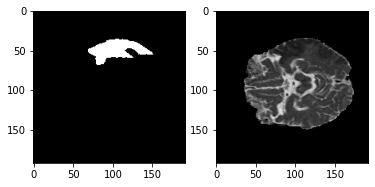

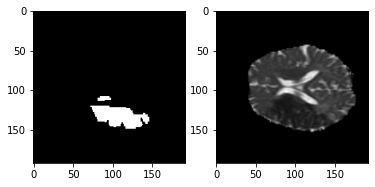

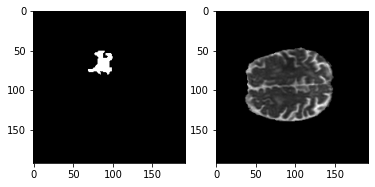

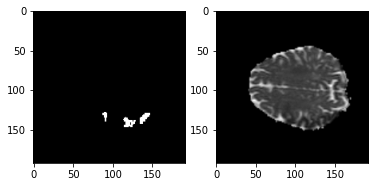

In [ ]:
for ith_batch, sample_batched in enumerate(validation_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['gt'].to('cuda')
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(y_train[0,:,:].cpu(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(X_train[0,0,:,:].cpu(),cmap='gray')
    if ith_batch==3:
      break
    

In [ ]:
import monai
train_files=[{'image':img,'gt':gt} for img,gt in zip(train_list, gt_list)]


monai_transforms = mtransforms.Compose([
    mtransforms.ScaleIntensityRangePercentilesd(['image','gt'],0,100,0,255,clip=True),                              
    #mtransforms.CropForegroundd(keys=['image','gt'],source_key='image',margin=0,channel_indices=1),
    mtransforms.Resized(['image'],spatial_size=192,size_mode='longest'),                
    mtransforms.ToTensord(keys=['image','gt'])]
    #transforms.Normalize(mean, std)
    )

monai_ds=monai.data.Dataset(data=train_files,transform=monai_transforms)
monai_trainloader=monai.data.DataLoader(monai_ds,batch_size=1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 


In [ ]:
###model

import torch
import torch.nn as nn
import torch.nn.functional as F

class Expand(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.unsqueeze(x, dim=0)

class Squeeze(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.squeeze(x, dim=1)

class SE_block(nn.Module):
    """[summary]
    
    Squeeze Excite block
    """
    def __init__(self, in_channels, ratio=16):
        super().__init__()
        self.avg_2d = F.adaptive_avg_pool2d
        self.dense_block = nn.Sequential(
            nn.Linear(in_channels, in_channels // ratio, bias=False),
            nn.ReLU(),
            nn.Linear(in_channels // ratio, in_channels, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        filters = x.size(1)
        reshape_size = (x.size(0), 1, 1, filters)
        se = self.avg_2d(x, (1, 1))
        se = torch.reshape(se, reshape_size)
        se = self.dense_block(se)
        se = se.permute(0, 3, 1, 2)
        return x * se

class BN_block2d(nn.Module):
    """
        2-d batch-norm block
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bn_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.bn_block(x)

class BN_block3d(nn.Module):
    """
        3-d batch-norm block
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bn_block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.bn_block(x)

class D_SE_Add(nn.Module):
    """
        D_SE_Add block
    """
    def __init__(self, in_channels, out_channels, mid_channels):
        super().__init__()
        
        self.conv3d_ = nn.Conv3d(in_channels, 1, kernel_size=1, padding=0)
        self.Squeeze = Squeeze()
        self.conv2d_ = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)
        self.ReLU = nn.ReLU()
        
        self.SE_block = SE_block(in_channels)
        
        self.squeeze_block_3d = nn.Sequential(
            nn.Conv3d(in_channels, 1, kernel_size=1, padding=0),
            Squeeze(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            SE_block(in_channels)
        )
        
    def forward(self, in_3d, in_2d):
        in_2d = self.SE_block(in_2d)
        in_3d = self.squeeze_block_3d(in_3d)

        return in_3d + in_2d

def up_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )




"""
    D-UNet: a dimension-fusion U shape network for chronic stroke lesion segmentation
    https://arxiv.org/pdf/1908.05104.pdf
"""


def weights_init_he(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)
    if isinstance(m, nn.Conv3d):
        torch.nn.init.kaiming_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

class DUnet(nn.Module):
    def __init__(self, in_channels, weights_init = True):
        super().__init__()

        self.in_channels = in_channels
        in_channels_3d = 1
        
        self.Expand = Expand
        self.MaxPool3d = nn.MaxPool3d(kernel_size=2)
        self.MaxPool2d = nn.MaxPool2d(kernel_size=2)
        self.Dropout = nn.Dropout(0.3)
        
        # 3d down
        self.bn_3d_1 = BN_block3d(in_channels_3d, in_channels_3d * 32)
        #self.bn_3d_2 = BN_block3d(in_channels_3d * 32, in_channels_3d * 64)
        self.bn_3d_2 = BN_block3d(in_channels_3d * 32, in_channels_3d * 96)
        #self.bn_3d_3 = BN_block3d(in_channels_3d * 64, in_channels_3d * 128)
        self.bn_3d_3 = BN_block3d(in_channels_3d * 96, in_channels_3d * 192)
        
        # 2d down
        
        self.bn_2d_1 = BN_block2d(in_channels, in_channels * 8)

        self.bn_2d_2 = BN_block2d(in_channels * 8, in_channels * 16)
        #self.se_add_2 = D_SE_Add(in_channels * 16, in_channels * 16, 2)
        self.se_add_2 = D_SE_Add(in_channels * 16, in_channels * 16, 3)
        
        self.bn_2d_3 = BN_block2d(in_channels * 16, in_channels * 32)
        self.se_add_3 = D_SE_Add(in_channels * 32, in_channels * 32, 1)
        
        self.bn_2d_4 = BN_block2d(in_channels * 32, in_channels * 64)

        self.bn_2d_5 = BN_block2d(in_channels * 64, in_channels * 128)
        
        # up

        self.up_block_1 = up_block(in_channels * 128, in_channels * 64)
        self.bn_2d_6 = BN_block2d(in_channels * 128, in_channels * 64)
        
        self.up_block_2 = up_block(in_channels * 64, in_channels * 32)
        self.bn_2d_7 = BN_block2d(in_channels * 64, in_channels * 32)
        
        self.up_block_3 = up_block(in_channels * 32, in_channels * 16)
        self.bn_2d_8 = BN_block2d(in_channels * 32, in_channels * 16)
        
        self.up_block_4 = up_block(in_channels * 16, in_channels * 8)
        self.bn_2d_9 = BN_block2d(in_channels * 16, in_channels * 8)
        
        self.conv_10 = nn.Sequential(
            nn.Conv2d(in_channels * 8, 1, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

        # He initialization stated in the original paper
        if weights_init:
            self.apply(weights_init_he)

    def forward(self, x):
        input3d = self.Expand()(x) # 1, batch_size, 4, 192, 192
        input3d = input3d.permute(1, 0, 2, 3, 4) # batch_size, 1, 4, 192, 192

        # 3d Stream
        conv3d1 = self.bn_3d_1(input3d)
        pool3d1 = self.MaxPool3d(conv3d1)

        conv3d2 = self.bn_3d_2(pool3d1)
        pool3d2 = self.MaxPool3d(conv3d2)

        conv3d3 = self.bn_3d_3(pool3d2)
        
        # 2d Encoding
        in_channels = self.in_channels

        conv1 = self.bn_2d_1(x)
        pool1 = self.MaxPool2d(conv1)

        conv2 = self.bn_2d_2(pool1)
        conv2 = self.se_add_2(conv3d2, conv2)
        pool2 = self.MaxPool2d(conv2)

        conv3 = self.bn_2d_3(pool2)
        conv3 = self.se_add_3(conv3d3, conv3)
        pool3 = self.MaxPool2d(conv3)

        conv4 = self.bn_2d_4(pool3)
        conv4 = self.Dropout(conv4)
        pool4 = self.MaxPool2d(conv4)

        conv5 = self.bn_2d_5(pool4)
        conv5 = self.Dropout(conv5)

        # Decoding

        up6 = self.up_block_1(conv5)
        merge6 = torch.cat(([conv4, up6]), 1)
        conv6 = self.bn_2d_6(merge6)

        up7 = self.up_block_2(conv6)
        merge7 = torch.cat(([conv3, up7]), 1)
        conv7 = self.bn_2d_7(merge7)

        up8 = self.up_block_3(conv7)
        merge8 = torch.cat(([conv2, up8]), 1)
        conv8 = self.bn_2d_8(merge8)

        up9 = self.up_block_4(conv8)
        merge9 = torch.cat(([conv1, up9]), 1)
        conv9 = self.bn_2d_9(merge9)

        conv10 = self.conv_10(conv9)

        return conv10

if __name__ == "__main__":

   model = DUnet(in_channels=6)
   model.to('cuda')

    #BATCH_SIZE = 1
    #input_batch = torch.Tensor(BATCH_SIZE, 6, 192, 192)
    #output_batch = model(input_batch)

    #print(output_batch.size()) # BATCH_SIZE, 1, 192, 192

In [ ]:
##LOSS

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/((inputs**2).sum() + (targets**2).sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE
  

#criterion =DiceBCELoss()


#Focal
ALPHA = 1.1
GAMMA = 0.48

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        n=len(targets)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

#DICE
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/((inputs**2).sum() + (targets**2).sum() + smooth)  
        
        #return 1 - dice
        return 1-dice


def ehl(y_pred,y_train):
  return FocalLoss()(y_pred,y_train)-torch.log(DiceLoss()(y_pred,y_train))



In [ ]:
import numpy as np
r = np.random.beta(5,2)
fig, ax = plt.subplots(1, 1)
ax.hist(r, density=False, histtype='stepfilled', alpha=0.2)
ax.legend()
plt.show()


NameError: ignored

In [ ]:
##optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 3*10**-4)

Epoch:  1 Batch:  0 Current Loss:  0.8040589094161987
Epoch:  1 Batch:  100 Current Loss:  0.2830027937889099
Epoch 1 completed
Average train loss is 0.3451618916571957: 
Average validation loss is 0.24012475843365128
Average validation dice coef is 0.24528681748622172
Epoch:  2 Batch:  0 Current Loss:  0.18467769026756287
Epoch:  2 Batch:  100 Current Loss:  0.19423642754554749
Epoch 2 completed
Average train loss is 0.21461383365604975: 
Average validation loss is 0.19870464785678968
Average validation dice coef is 0.41682316000397146
Epoch:  3 Batch:  0 Current Loss:  0.46357959508895874
Epoch:  3 Batch:  100 Current Loss:  0.21102869510650635
Epoch 3 completed
Average train loss is 0.34370283930473133: 
Average validation loss is 0.37903767924856496
Average validation dice coef is 0.3951009028666729
Epoch:  4 Batch:  0 Current Loss:  0.0534999817609787
Epoch:  4 Batch:  100 Current Loss:  0.04219917953014374
Epoch 4 completed
Average train loss is 0.034368940080477764: 
Average val

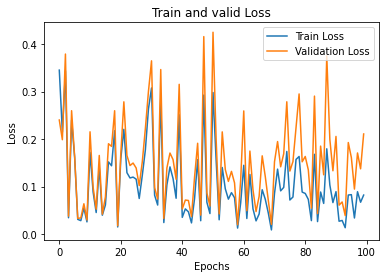

In [ ]:
###Train loop
### Focal Loss function
epochs = 100


train_running_loss_history = []
validation_running_loss_history =[]
dice_coeff_beta=[]
beta_l=[]

for e in range(epochs):
  dice_loss=0.0
  train_running_loss = 0.0
  validation_running_loss = 0.0
 ###generate 
  beta = np.random.beta(5,2)
  beta_l.append(beta)

  
  model.train()
  
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['gt'].to('cuda')

    optimizer.zero_grad()
    y_pred = model(X_train)
   #out = (y_pred + 0.5).int().float()
    
    #loss = FocalLoss()(y_pred,y_train)/N-torch.log(DiceLoss()(y_pred,y_train))
    #loss = criterion(y_pred, y_train)
    

    loss = beta*FocalLoss()(y_pred,y_train.float())+(1-beta)*DiceLoss()(y_pred,y_train.float())
    loss.backward()
    optimizer.step()
    
    if ith_batch % 100 == 0:
     print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      
    train_running_loss += loss.item()




 ###### Validation  
  else:
    with torch.no_grad(): 
      model.eval()
      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val = sample_batched['image'].to('cuda')
          y_val = sample_batched['gt'].to('cuda')
          y_pred = model(X_val)
          #out_val = (y_out + 0.5).int().float()        
          val_loss = beta*FocalLoss()(y_pred,y_val.float())+(1-beta)*DiceLoss()(y_pred,y_val.float())
          validation_running_loss += val_loss.item()
          dicel=DiceLoss()(y_pred, y_val)
          dice_loss+=dicel.item()
  #if (e+1)%10==0:
    #torch.save({'model_state_dict':model.state_dict(), 
                #'epoch':e,
                #'optimizer_state_dict':optimizer.state_dict(),
                #'loss':loss.item()}, "/content/gdrive/MyDrive/Stroke/bs_2_Focal_Loss_epoch{}".format(e+1))


 #########################Print error         

  print("================================================================================")
  print("Epoch {} completed".format(e + 1))
      
  train_epoch_loss = train_running_loss / len(train_loader)
  validation_epoch_loss = validation_running_loss / len(validation_loader)
  valid_dice_score=1-dice_loss/len(validation_loader)    
  print("Average train loss is {}: ".format(train_epoch_loss))
  print("Average validation loss is {}".format(validation_epoch_loss))
  print("Average validation dice coef is {}".format(valid_dice_score))

  print("================================================================================")
  train_running_loss_history.append(train_epoch_loss)
  validation_running_loss_history.append(validation_epoch_loss)
  dice_coeff_beta.append(valid_dice_score)

torch.cuda.empty_cache()

plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()
plt.title("Train and valid Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
max_dice_coef=max(dice_coeff_beta)
index=np.argmax(dice_coeff_beta)+1
print("Highest validation dice score: {} at epoch {} ".format(max_dice_coef,index))
print("Corresponding beta: {} ".format(beta_l[index]))





In [ ]:
plt.plot(dice_coeff_beta, label = 'Focal')
print('average validation dice coefficient', np.mean(dice_coeff_beta))
plt.legend()
plt.title("dice score of beta loss functions")
plt.ylabel("dice score")
plt.xlabel("Epochs")


NameError: ignored

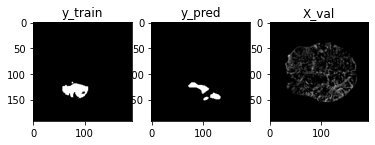

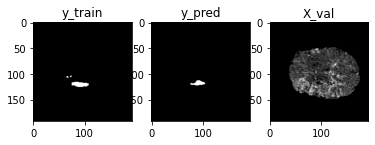

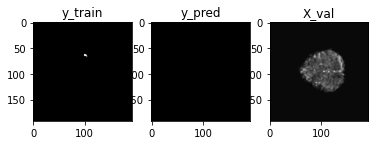

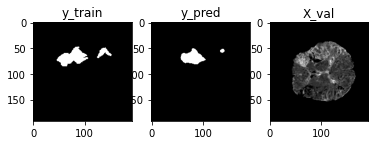

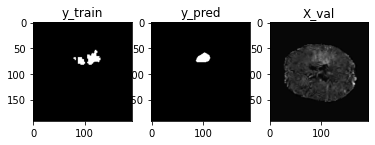

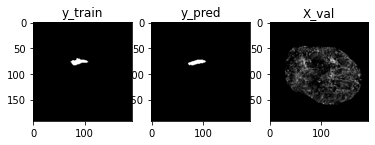

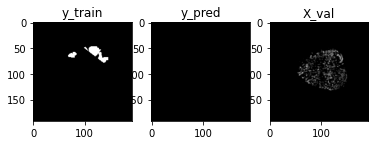

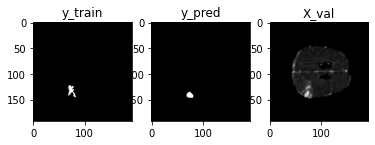

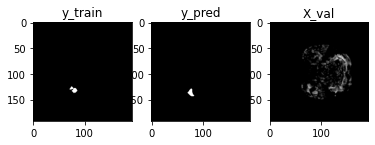

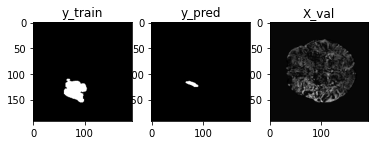

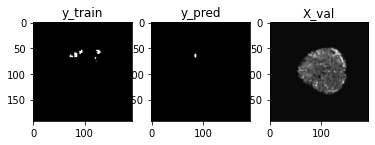

In [ ]:

with torch.no_grad():
  model.eval()
  for ith_batch, sample_batched in enumerate(validation_loader):
    X_val = sample_batched['image'].to('cuda')
    y_val = sample_batched['gt'].to('cuda')
    y_pred = model(X_val)




    fig = plt.figure()
    fig.add_subplot(1, 3, 1)
    plt.imshow(y_val.cpu()[0,:,:]>0.5,cmap='gray')
    plt.gca().set_title('y_train')
    fig.add_subplot(1, 3, 2)
    plt.imshow(y_pred.cpu()[0,0,:,:]>0.5,cmap='gray')
    plt.gca().set_title('y_pred')
    fig.add_subplot(1, 3, 3)
    plt.imshow((X_val[0,1,:,:].cpu()),cmap='gray')
    plt.gca().set_title('X_val')
    if ith_batch==10:
      break
    
      

In [ ]:
###load checkpoint

#model.load_state_dict(torch.load("/content/gdrive/MyDrive/Stroke/ehl_epoch15"))


In [ ]:
#############################Dice Loss Function

epochs = 100


train_running_loss_history = []
validation_running_loss_history =[]
dice_coeff_dicefn=[]

for e in range(epochs):
  dice_loss=0.0
  train_running_loss = 0.0
  validation_running_loss = 0.0
  
  model.train()
  
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['gt'].to('cuda')

    optimizer.zero_grad()
    y_pred = model(X_train)
   #out = (y_pred + 0.5).int().float()
    
    #loss = FocalLoss()(y_pred,y_train)/N-torch.log(DiceLoss()(y_pred,y_train))
    #loss = criterion(y_pred, y_train)
    loss = DiceLoss()(y_pred,y_train.float())
    loss.backward()
    optimizer.step()
    
    if ith_batch % 100 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      
    train_running_loss += loss.item()




 ###### Validation  
  else:
    with torch.no_grad(): 
      model.eval()
      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val = sample_batched['image'].to('cuda')
          y_val = sample_batched['gt'].to('cuda')
          y_pred = model(X_val)
          #out_val = (y_out + 0.5).int().float()        
          val_loss = DiceLoss()(y_pred, y_val.float())
          dicel=DiceLoss()(y_pred, y_val.float())
          validation_running_loss += val_loss.item()
          dice_loss+=dicel.item()
  #if (e+1)%10==0:
   # torch.save({'model_state_dict':model.state_dict(), 
                #'epoch':e,
                #'optimizer_state_dict':optimizer.state_dict(),
                #'loss':loss.item()}, "/content/gdrive/MyDrive/Stroke/bs_2_Dice_epoch{}".format(e+1))


 #########################Print error         

  print("================================================================================")
  print("Epoch {} completed".format(e + 1))
      
  train_epoch_loss = train_running_loss / len(train_loader)
  validation_epoch_loss = validation_running_loss / len(validation_loader)
  valid_dice_score=1-dice_loss/len(validation_loader)    
  print("Average train loss is {}: ".format(train_epoch_loss))
  print("Average validation loss is {}".format(validation_epoch_loss))
  print("Average validation dice coef is {}".format(valid_dice_score))

  print("================================================================================")
  train_running_loss_history.append(train_epoch_loss)
  validation_running_loss_history.append(validation_epoch_loss)
  dice_coeff_dicefn.append(valid_dice_score)

torch.cuda.empty_cache()



plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()
plt.title("Train and valid Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
max_dice_coef=max(dice_coeff_dicefn)
index=np.argmax(dice_coeff_dicefn)+1
print("Highest validation dice score: {} at epoch {} ".format(max_dice_coef,index))

Epoch:  1 Batch:  0 Current Loss:  0.8751709461212158
Epoch:  1 Batch:  100 Current Loss:  0.9689502716064453
Epoch 1 completed
Average train loss is 0.6959762944750589: 
Average validation loss is 0.6269429084416982
Average validation dice coef is 0.3730570915583018
Epoch:  2 Batch:  0 Current Loss:  0.26705265045166016
Epoch:  2 Batch:  100 Current Loss:  0.6622797250747681
Epoch 2 completed
Average train loss is 0.5559362062852676: 
Average validation loss is 0.5905819535255432
Average validation dice coef is 0.4094180464744568
Epoch:  3 Batch:  0 Current Loss:  0.3216513991355896
Epoch:  3 Batch:  100 Current Loss:  0.2183787226676941
Epoch 3 completed
Average train loss is 0.4973499485074657: 
Average validation loss is 0.5874655262843983
Average validation dice coef is 0.4125344737156017
Epoch:  4 Batch:  0 Current Loss:  0.40526866912841797
Epoch:  4 Batch:  100 Current Loss:  0.7870422005653381
Epoch 4 completed
Average train loss is 0.4752619842143908: 
Average validation loss

KeyboardInterrupt: ignored